# Predict 1-log and 6-log Reduction Dose for Ciprofloxacin Treatment

In [1]:
import os

import chi
import chi.plots
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pints
import seaborn as sns
import xarray as xr

Define convenience functions.

In [2]:
def format_posterior(posterior, param_names):
    """
    Returns posterior samples as numpy.ndarray.
    """
    n_chains = len(posterior.chain.values)
    n_draws = len(posterior.draw.values)
    n_parameters = len(posterior)
    numpy_posterior = np.empty(shape=(n_chains * n_draws, n_parameters))
    for param_id, param in enumerate(param_names):
        # Get samples as numpy array
        samples = posterior[param].values

        # Flatten samples and make sure order is preserved
        numpy_posterior[:, param_id] = samples.flatten()

    return numpy_posterior

def load_inference_data(end_experiment):
    """
    Returns the posterior samples and the model likelihoods. The posterior
    samples for each model are formatted as numpy.ndarray of shape
    (n_samples, n_parameters).
    """
    # Specify model names
    model_names = ['K_model', 'KP_model', 'KR_model']

    # Define a map from model names to names in saved posteriors
    parameter_names = [
        [  # K model
            'pooled_initial_bacterial_count',
            'pooled_ec50',
            'pooled_growth_rate',
            'pooled_max_kill_rate',
            'pooled_sigma_log'],
        [  # KP model
            'pooled_initial_bacterial_count',
            'pooled_death_rate',
            'pooled_growth_rate',
            'pooled_kill_rate',
            'pooled_rate_to_dividing',
            'pooled_rate_to_nondividing',
            'pooled_sigma_log'],
        [  # KR model
            'pooled_initial_bacterial_count',
            'pooled_adapted_ec50',
            'pooled_growth_rate',
            'pooled_adapted_max_kill_rate',
            'pooled_wild_type_kill_rate',
            'pooled_mutation_rate',
            'pooled_sigma_log']
    ]

    # Load posteriors and AIC scores
    n_models = len(model_names)
    aic_scores = np.empty(shape=n_models)
    parameters = []
    directory = os.getcwd()
    for id_m, model in enumerate(model_names):
        # Load inference data
        inf_data = xr.load_dataset(
            directory + '/derived_data/%s_posterior_%dh.nc'
            % (model, int(end_experiment))
        )
        parameters.append(format_posterior(inf_data, parameter_names[id_m]))
        aic_scores[id_m] = inf_data.attrs['AIC score']

    # Compute elpd deltas to avoid numerical overflow
    aic_scores -= np.min(aic_scores)

    # Compute weights
    weights = np.exp(-aic_scores / 2) / np.sum(np.exp(-aic_scores / 2))

    return parameters, weights

## Show data

In [3]:
# Get data
directory = os.getcwd()
data = pd.read_csv(directory + '/derived_data/measurements.csv')

# Create scatter plots of data
fig = chi.plots.PDTimeSeriesPlot()
fig.add_data(data, biomarker='Bacterial count')
fig.set_axis_labels(xlabel='Time in hours', ylabel='Bacterial count in CFU/mL')
fig.show()

## Define candidate models

Recall that the data-generating model is the KR model.
We will use the data-generating model (with the true model parameters) as a
reference to evaluate the reliability of the model predictions.

In [4]:
# Define K model
directory = os.path.dirname(os.path.dirname(os.getcwd()))
k_model = chi.PharmacokineticModel(directory + '/models/K_model.xml')
k_model.set_administration(compartment='central')
k_model.set_parameter_names(names={
    'myokit.bacterial_count': 'Initial bacterial count in CFU/ml',
    'myokit.concentration_e50': 'EC 50 in ng/ml',
    'myokit.growth_rate': 'Growth rate in 1/h',
    'myokit.kappa': 'Max. kill rate in 1/h'})
k_model.set_outputs(['myokit.bacterial_count'])
k_model.set_output_names({
    'myokit.bacterial_count': 'Bacterial count in CFU/ml'})
k_model = chi.ReducedMechanisticModel(
    k_model)
k_model.fix_parameters({
    'central.drug_amount': 0,
    'dose.drug_amount': 0,
    'myokit.bacterial_count_adapted': 0,
    'dose.absorption_rate': 2.7,           # in 1/h, Sanchez et al
    'central.size': 3.7 * 70,              # in L/kg, Sanchez et al for 70 kg
    'myokit.elimination_rate': 0.17,       # in 1/h, Sanchez et al
    'myokit.gamma': 1})

# Define KP model
kp_model = chi.PharmacokineticModel(directory + '/models/KP_model.xml')
kp_model.set_administration(compartment='central', direct=False)
kp_model.set_parameter_names(names={
    'myokit.bacterial_count_susceptible': 'Initial bacterial count in CFU/ml',
    'myokit.death_rate': 'Death rate in 1/h',
    'myokit.growth_rate': 'Growth rate in 1/h',
    'myokit.kappa': 'Kill rate in ml/ng/h',
    'myokit.transition_rate_12': 'Transition rate to dividing in 1/h',
    'myokit.transition_rate_21': 'Transition rate to non-dividing in ml/ng/h'})
kp_model.set_outputs(['myokit.total_bacterial_count'])
kp_model.set_output_names({
    'myokit.total_bacterial_count': 'Bacterial count in CFU/ml'})
kp_model = chi.ReducedMechanisticModel(
    kp_model)
kp_model.fix_parameters({
    'central.drug_amount': 0,
    'dose.drug_amount': 0,
    'myokit.bacterial_count_adapted': 0,
    'dose.absorption_rate': 2.7,           # in 1/h, Sanchez et al
    'central.size': 3.7 * 70,              # in L/kg, Sanchez et al for 70 kg
    'myokit.elimination_rate': 0.17,       # in 1/h, Sanchez et al
    'myokit.gamma': 1})

# Define KR model
kr_model = chi.PharmacokineticModel(directory + '/models/KR_model.xml')
kr_model.set_administration(compartment='central', direct=False)
kr_model.set_parameter_names(names={
    'myokit.bacterial_count_susceptible': 'Initial bacterial count in CFU/ml',
    'myokit.concentration_e50_adapted': 'Adapted EC 50 in ng/ml',
    'myokit.growth_rate': 'Growth rate in 1/h',
    'myokit.kappa_adapted': 'Adapted max. kill rate in 1/h',
    'myokit.kappa_susceptible': 'Wild type kill rate in ml/ng/h',
    'myokit.mutation_rate': 'Mutation rate in ml/ng/h'})
kr_model.set_outputs(['myokit.total_bacterial_count'])
kr_model.set_output_names({
    'myokit.total_bacterial_count': 'Bacterial count in CFU/ml'})
kr_model = chi.ReducedMechanisticModel(
    kr_model)
kr_model.fix_parameters({
    'central.drug_amount': 0,
    'dose.drug_amount': 0,
    'myokit.bacterial_count_adapted': 0,
    'dose.absorption_rate': 2.7,           # in 1/h, Sanchez et al
    'central.size': 3.7 * 70,              # in L/kg, Sanchez et al for 70 kg
    'myokit.elimination_rate': 0.17,       # in 1/h, Sanchez et al
    'myokit.gamma': 1})

## Predictions of 1-log reduction dose

We want to predict the dose that leads after 24h to a 1-log (10-fold) reduction
of the bacterial population. We consider a dosing regimen $r$ that administers
ciprofloxacin orally twice a day.

### Find true reduction dose

The true 1-log reduction dose can be straightforwardly computed from the
data-generating model by solving

$$
    \bar{y}(\psi , t=24, r) = \bar{y}_0 / 10
$$

for the dosing regimen $r$, where $\bar{y}_0 = \bar{y}(\psi , t=0, r)$ is the
true bacterial count at $t=0$.

In [5]:
class TrueXLogReductionDose(pints.ErrorMeasure):
    """
    Defines a pints.ErrorMeasure that can be used to find the true
    dose that leads to a X-log reduction at time t.

    Can be called with a dose amount and returns the squared distance
    of the log reduction at time t from the target log reduced bacterial
    population.
    """
    def __init__(self, log_reduction, time):
        self._model = kr_model
        self._parameters = [
            1E6,     # Initial bacterial count in CFU/ml
            191,     # Adapated EC50 in ng/ml
            0.77,    # Growth rate in 1/h
            1.61,    # Adapted max. kill rate in 1/h
            0.003,   # Wild type max. kill rate in 1/h
            5E-5,    # Max. mutation rate in 1/h
        ]
        self._time = [float(time)]
        self._target_reduction = -int(log_reduction)

    def __call__(self, dose):
        """
        Returns the squared error of the target population size to the
        true population size at time t for the administered dose.

        Input: dose in mg
        """
        # Convert dose to ng
        dose = dose[0] * 1E3

        # Compute error
        self._model.set_dosing_regimen(dose=dose, start=0, period=12)
        predicted_pop = self._model.simulate(
            parameters=self._parameters, times=self._time)[0, 0]
        log_reduction = np.log10(predicted_pop / self._parameters[0])
        squared_error = (self._target_reduction - log_reduction) ** 2

        return squared_error

    def n_parameters(self):
        """
        Returns the number of parameters of the optimisation problem.
        (We just want to find the dose, so it is 1)
        """
        return 1

# Find true 1-log reduction dose
problem = TrueXLogReductionDose(log_reduction=1, time=24)
initial_guess = [200]
optimiser = pints.OptimisationController(
    problem, x0=initial_guess, method=pints.NelderMead)
optimiser.set_log_to_screen(False)
true_dose, squared_error = optimiser.run()
print('True dose: ', true_dose)
print('Squared error: ', squared_error)

True dose:  [163.82753914]
Squared error:  3.4902336099777226e-22


### Predict reduction dose with MAA approach

We can find the 1-log reduction dose analogously to the optimisation routine
above, i.e. by solving $\bar{y}(\psi , t=24, r) = \bar{y}_0 / 10$. The main
difference for MAA is that we have to compute the predicted bacterial
count at time t by the weighted average of the mean predictions across the
models

$$
    \bar{y}(\mathcal{D}, t, r) = \sum_m w_m\, \mathbb{E}_m [y | \mathcal{D}, t, r].
$$

We will approximate the exact expectation of $y$ by an empirical average over
the posterior samples

$$
    \mathbb{E}_m [y | \mathcal{D}, t, r] \approx
        \frac{1}{S} \sum _{s=1}^S y(\psi ^s, \sigma ^s, t, r),
$$
where $S$ is the sample size and the superscript indexes the samples from the
posterior distribution.

In [6]:
class MAAXLogReductionDose(pints.ErrorMeasure):
    """
    Defines a pints.ErrorMeasure that can be used to find the MAA prediction of
    the dose that leads to a X-log reduction at time t.

    Can be called with a dose amount and returns the squared distance
    of the log reduction at time t from the target log reduced bacterial
    population.
    """
    def __init__(self, log_reduction, time, end_experiment):
        self._models = [k_model, kp_model, kr_model]
        self._parameters, self._weights = load_inference_data(
            end_experiment=end_experiment)
        self._time = [float(time)]
        self._target_reduction = -int(log_reduction)
        self._initial_pop = 1E6
        self._sample_size = 300

        # Make sure all models start with the correct initial population size
        # shape: (n_samples, n_parameters)
        self._parameters[0][:, 0] = self._initial_pop
        self._parameters[1][:, 0] = self._initial_pop
        self._parameters[2][:, 0] = self._initial_pop

    def __call__(self, dose):
        """
        Returns the squared error of the target population size to the
        true population size at time t for the administered dose.

        Input: dose in mg
        """
        # Convert dose to ng
        dose = dose[0] * 1E3

        # Set dosing regimen
        for model in self._models:
            model.set_dosing_regimen(dose=dose, start=0, period=12)

        # Compute error
        predicted_pop = self._predict_population()
        log_reduction = np.log10(predicted_pop / self._initial_pop)
        squared_error = (self._target_reduction - log_reduction) ** 2

        return squared_error

    def _predict_population(self):
        """
        Returns the predicted population size.
        """
        # Estimate mean y for each model
        mean_y = np.empty(shape=3)
        for model_id, posterior in enumerate(self._parameters):
            model = self._models[model_id]
            mean_y[model_id] = self._predict_population_with_candidate_model(
                model, posterior)

        # Compute MAA prediction as weighted average of the means
        predicted_pop = np.average(mean_y, weights=self._weights)
        return predicted_pop

    def _predict_population_with_candidate_model(self, model, posterior):
        """
        Returns an estimate of the expected y for the model.
        """
        # Predict y_bar for each posterior sample
        y_bar = np.empty(shape=self._sample_size)
        posterior_samples = posterior[
            np.random.randint(0, len(posterior), size=self._sample_size)]
        for sample_id, parameter_sample in enumerate(posterior_samples):
            y_bar[sample_id] = model.simulate(
                parameters=parameter_sample[:-1], times=self._time)[0, 0]

        # Add noise to predict y
        noise = np.random.normal(size=self._sample_size)
        sigma = posterior_samples[:, -1]
        y = y_bar * np.exp(-sigma**2/2 + sigma * noise)

        return np.mean(y)

    def n_parameters(self):
        """
        Returns the number of parameters of the optimisation problem.
        (We just want to find the dose, so it is 1)
        """
        return 1


def predict_reduction_dose_maa(log_reduction, time, end_experiment):
    """
    Returns the log-reduction dose associated with the time.

    The end of the experiment specifies which model parameters are used,
    i.e. how much data was available when the model parameters were learned.
    """
    problem = MAAXLogReductionDose(log_reduction, time, end_experiment)
    initial_guess = [200]
    optimiser = pints.OptimisationController(
        problem, x0=initial_guess, method=pints.NelderMead)
    optimiser.set_log_to_screen(False)
    optimiser.set_max_iterations(100)
    dose, squared_error = optimiser.run()

    return dose, squared_error

# Example: Find 1-log reduction dose after 30h
maa_dose, squared_error = predict_reduction_dose_maa(
    log_reduction=1, time=24, end_experiment=30)
print('MAA dose prediction after learning from 30h of experiments: ', maa_dose)
print('Squared error: ', squared_error)

MAA dose prediction after learning from 30h of experiments:  [162.50518799]
Squared error:  1.285120582688919e-07


### Predict 1-log reduction dose with MS and PAM

In order to predict the reduction dose with the candidate models in a way
that reflects the remaining uncertainty, we solve conceptually the same
optimisation problem as before

$$
    y(\mathcal{D}, t=24, r) = \bar{y}_0 / 10.
$$

Note, however, that the limited data $\mathcal{D}$ leaves uncertainty about the
bacterial count prediction, i.e. $p_m(y | \mathcal{D}, t=24, r)$. As a result,
we will only be able to predict a distribution of probable reduction doses,
which reflects the remaining uncertainty.

One way to infer this distribution of probable reduction doses is to
repeatedly sample a realisation of $y$ from $p_m(y | \mathcal{D}, t=24, r)$ and
then to find the dose amount that satisfies $y = \bar{y}_0 / 10$ for this
realisation.

The PAM predictions of the reduction doses is
given by the combined distributions of probable reduction doses of all likely
candidate models.


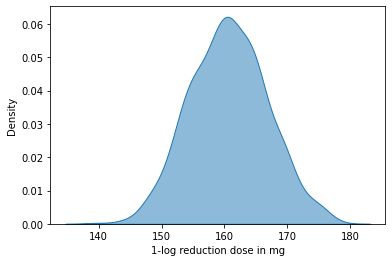

In [7]:
class MSXLogReductionDose(pints.ErrorMeasure):
    """
    Defines a pints.ErrorMeasure that can be used to find the
    dose that leads to a X-log reduction at time t.

    Can be called with a dose amount and returns the squared distance
    of the log reduction at time t from the target log reduced bacterial
    population.
    """
    def __init__(self, model, log_reduction, time):
        self._model = model
        self._parameters = None
        self._noise = None
        self._sigma = None
        self._time = [float(time)]
        self._target_reduction = -int(log_reduction)

    def __call__(self, dose):
        """
        Returns the squared error of the target population size to the
        true population size at time t for the administered dose.

        Input: dose in mg
        """
        # Convert dose to ng and set dosing regimen
        dose = dose[0] * 1E3
        self._model.set_dosing_regimen(dose=dose, start=0, period=12)

        # Sample predicted y at t=24
        y_bar = self._model.simulate(
            parameters=self._parameters, times=self._time)[0, 0]
        y = y_bar * np.exp(-self._sigma**2/2 + self._sigma * self._noise)
        y0 = self._parameters[0]
        log_reduction = np.log10(y / y0)
        squared_error = (self._target_reduction - log_reduction) ** 2

        return squared_error

    def n_parameters(self):
        """
        Returns the number of parameters of the optimisation problem.
        (We just want to find the dose, so it is 1)
        """
        return 1

    def set_model_parameters(self, parameters):
        """
        Sets the parameters of the candidate model.

        Assumes that the first k-1 parameters are the parameters of the
        candidate model, and the last parameter is the standard deviation
        of the lognormal error.
        """
        assert self._model.n_parameters() == (len(parameters) - 1)
        self._parameters = parameters[:-1]
        self._sigma = parameters[-1]

    def set_noise(self, noise):
        """
        Sets realisation of the noise. Expects a sample from a standard
        Gaussian distribution.
        """
        self._noise = float(noise)


def prediction_reduction_dose_pam(
        log_reduction, time, end_experiment, weight_thresh=1E-3):
    """
    Returns the log-reduction dose associated with the time.

    The end of the experiment specifies which model parameters are used,
    i.e. how much data was available when the model parameters were learned.
    """
    n_samples = 1000
    models = [k_model, kp_model, kr_model]
    n_models = len(models)
    initial_guess = [200]
    tolerated_squared_error = 1E-6

    # Sample reduction doses
    doses = np.empty(shape=(n_models, n_samples))
    posteriors, weights = load_inference_data(end_experiment)
    for m_id, model in enumerate(models):
        # Skip if model has not sufficient likelihood
        if weights[m_id] < weight_thresh:
            doses[m_id] = np.nan
            continue

        # Sample from posterior and sample noise realisations
        posterior = posteriors[m_id]
        posterior = posterior[
            np.random.randint(0, len(posterior), size=n_samples)]
        noise = np.random.normal(size=n_samples)

        # Find reduction dose for sample
        problem = MSXLogReductionDose(model, log_reduction, time)
        for sample_id in range(n_samples):
            problem.set_model_parameters(posterior[sample_id])
            problem.set_noise(noise[sample_id])
            optimiser = pints.OptimisationController(
                problem, x0=initial_guess, method=pints.NelderMead)
            optimiser.set_log_to_screen(False)
            optimiser.set_max_iterations(100)
            dose, squared_error = optimiser.run()
            
            if squared_error < tolerated_squared_error:
                doses[m_id, sample_id] = dose
            else:
                doses[m_id, sample_id] = np.nan

    return doses, weights

# Example: Find 1-log reduction dose distribution after 30h with KR model
np.random.seed(1)
doses, weights = prediction_reduction_dose_pam(
    log_reduction=1, time=24, end_experiment=30)

# Visualise reduction dose distribution
sns.kdeplot(
    data=pd.DataFrame({'1-log reduction dose in mg': doses[2]}),
    x='1-log reduction dose in mg', fill=True,
    common_norm=False, alpha=.5, linewidth=1,
    legend=False)
plt.show()

### Predict 1-log reduction doses with all approaches (MS, MAA, PAM) for different amounts of available data

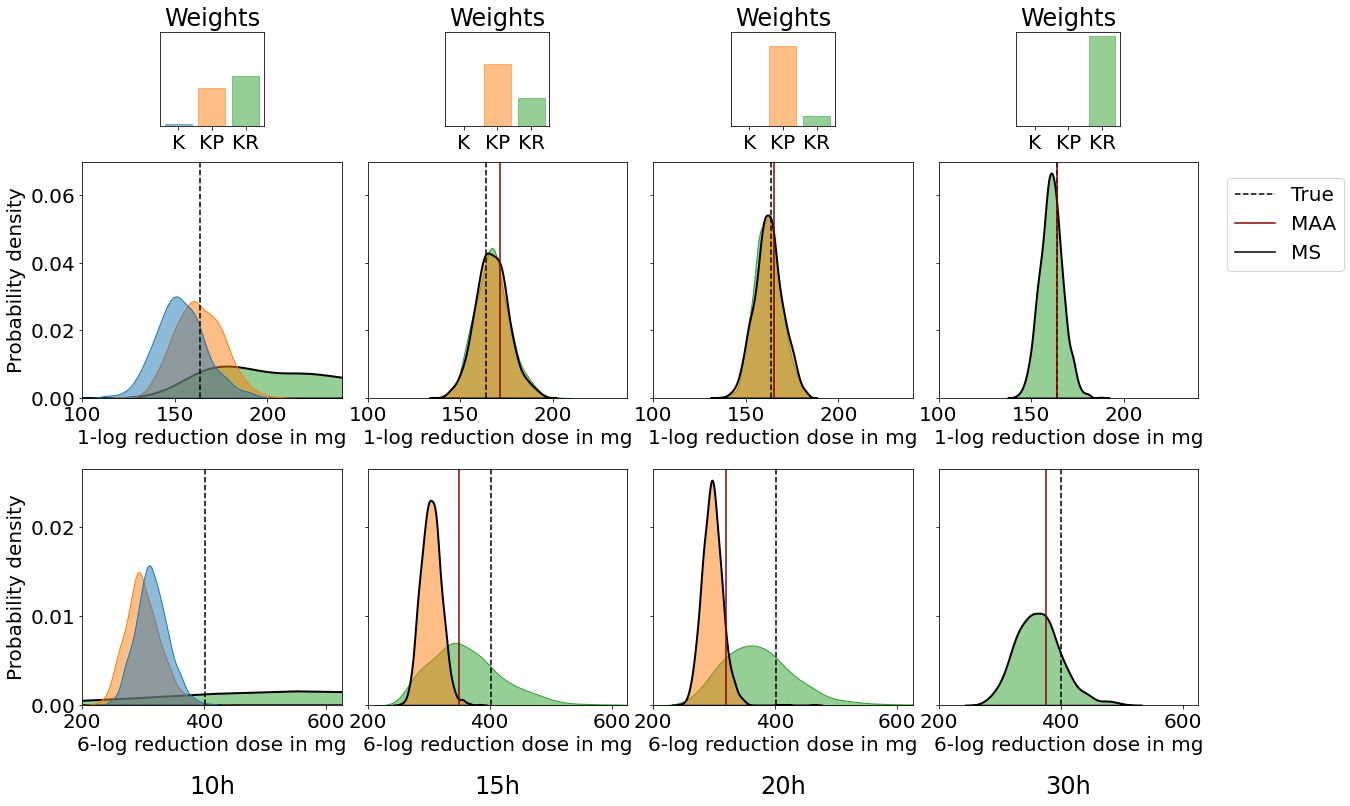

In [126]:
# Setup
time = 24
log_reductions = [1, 6]
experiment_durations = [10, 15, 20, 30]
n_experiments = len(experiment_durations)
weight_thresh = 1E-3

# Fix seed for reproducibility
np.random.seed(1)

# Find true log reduction doses
results = []
for log_reduction in log_reductions:
    problem = TrueXLogReductionDose(log_reduction, time)
    initial_guess = [200]
    optimiser = pints.OptimisationController(
        problem, x0=initial_guess, method=pints.NelderMead)
    optimiser.set_log_to_screen(False)
    true_dose, _ = optimiser.run()

    # Predict reduction doses and visualise results
    maa_doses = []
    pam_doses = []
    model_weights = []
    for exp_id, end_experiment in enumerate(experiment_durations):
        # Predict reduction dose with MAA
        maa_dose, _ = predict_reduction_dose_maa(
            log_reduction, time, end_experiment)
        maa_doses.append(maa_dose)

        # Predict reduction dose with PAM
        pam_dose, weights = prediction_reduction_dose_pam(
            log_reduction, time, end_experiment, weight_thresh)
        pam_doses.append(pam_dose)
        model_weights.append(weights)

    # Store results
    results.append([true_dose, maa_doses, pam_doses, model_weights])

# Plots results
fontsize = '20'
plt.rcParams['font.size'] = fontsize
fig, axes = plt.subplots(
    2, n_experiments, figsize=(20, 10), sharey='row', sharex='row')
plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
axes[0, 0].set_ylabel('Probability density', fontsize=fontsize)
axes[1, 0].set_ylabel('Probability density', fontsize=fontsize)
axes[0, 0].set_xlim([100, 240])
axes[1, 0].set_xlim([200, 625])

# Predict reduction doses and visualise results
result_captions = ['1-log reduction dose in mg', '6-log reduction dose in mg']
for log_id, caption in enumerate(result_captions):
    true_dose, maa_doses, pam_doses, model_weights = results[log_id]
    for exp_id, end_experiment in enumerate(experiment_durations):
        # Add title to subfigure
        if log_id == 1:
            axes[log_id, exp_id].set_title('%dh' % (end_experiment), y=-0.4)

        # Plot true dose response
        axes[log_id, exp_id].axvline(
            x=true_dose, color='black', linestyle='--', label='True')

        # Plot PAM prediction: Dose distributions
        df = []
        colors = []
        pam_dose = pam_doses[exp_id]
        weights = model_weights[exp_id]
        for model_id, weight in enumerate(weights):
            # Skip models with insufficient weight
            if weight < weight_thresh:
                continue
            dataframe = pd.DataFrame(
                data=pam_dose[model_id], columns=[caption])
            dataframe['Model'] = ['K', 'KP', 'KR'][model_id]
            df.append(dataframe)
            colors.append(sns.color_palette()[model_id])
        df = pd.concat(df, ignore_index=True)
        sns.kdeplot(
            data=df, x=caption, hue="Model", fill=True,
            common_norm=False, alpha=.5, linewidth=1, ax=axes[log_id, exp_id],
            palette=colors, legend=False)

        # Plot PAM prediction: Weights
        if log_id == 0:
            # inset_axes = axes[log_id, exp_id].inset_axes(
            #     bounds=[0.575, 0.45, 0.4, 0.4])
            inset_axes = axes[log_id, exp_id].inset_axes(
                bounds=[0.3, 1.15, 0.4, 0.4])
            n_models = 3
            x_pos = np.arange(n_models)
            colors = sns.color_palette()[:n_models]
            inset_axes.bar(
                x_pos, weights, align='center', alpha=0.5, color=colors,
                edgecolor=colors)
            inset_axes.set_xticks(x_pos)
            inset_axes.set_xticklabels(['K', 'KP', 'KR'])
            inset_axes.set_yticks([])
            inset_axes.set_yticklabels([])
            inset_axes.set_title('Weights')
            inset_axes.set_ylim([0, 1.05])

        # Plot MAA prediction
        maa_dose = maa_doses[exp_id]
        axes[log_id, exp_id].axvline(x=maa_dose, color='darkred', label='MAA')

        # Highlight MS prediction
        idx = 2 - np.argmax(weights)
        axes[log_id, exp_id].collections[idx]._linewidths = np.array([2])
        axes[log_id, exp_id].collections[idx]._original_edgecolor = np.array(
            [[0., 0., 0., 1.]])

# Add a curve outide visible range to add MS to legend
axes[0, 0].axvline(x=1E3, color='black', label='MS')

# Set legend
axes[0, 0].legend(bbox_to_anchor=(4.9 ,0.975))

directory = os.getcwd()
plt.savefig(
    directory + '/log_reduction_doses.pdf', bbox_inches='tight')
plt.show()